# Analyses Descriptives - Qualité de l'Air et Données Socio-Économiques
**Auteur:** Aymeric et Théo  
**Objectif:** Consolider les données urbaines, touristiques et de qualité de l'air pour analyser les corrélations et la représentativité des stations de mesure.

Commençons par importer les bibliothèques principales pour le traitement de données, la visualisation et la modélisation, ainsi que les scripts contenants les fonctions les plus volumineuses. Tous les imports sont faits au début pour les centraliser et ainsi éviter de les oublier ou de les répéter plusieurs fois.

In [1]:
# 1. Configuration et Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
from scripts import preprocessing as prep
from scripts import descriptive_visualization as viz

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
viz.setup_styles()

print("Environnement chargé avec succès.")

Environnement chargé avec succès.


## Partie 1 : Traitement des données Villes & Tourisme
Nous chargeons les données brutes, telles que récupérées sur le site de l'INSEE et de Geodair. Nos données économiques et démographiques (éco-démo dans la suite) sont divisées en 2 datasets, qu'il convient alors de fusionner pour n'en manipuler qu'un seul, contenant toutes les informations sur les villes. Cette fusion des deux datasets requiert d'être vigilant aux noms et types des variables sur lesquelles s'opère la jointure. A ce titre, des conversions de des renommages sont effectués.

Aussi, le champs de notre étude ne porte que sur les villes en France métropolitaine. Ainsi, les villes de Corse et d'outre-mer sont supprimées de notre base de données.

In [2]:
# Chargement et Preprocessing Villes
# Chemins d'accès
path_air = "data/raw_data/data_air_2022.csv"
path_villes = "data/raw_data/data.csv"
path_tourisme = "data/raw_data/BDD_tourisme_communes_2022.csv"

# Chargement initial des datasets
df_raw_villes, df_air = prep.load_and_merge_cities(path_air, path_villes, path_tourisme)

print(f"Après fusion : {df_raw_villes.shape[0]} lignes, {df_raw_villes.shape[1]} colonnes")
print(f"Doublons détectés : {df_raw_villes.duplicated().sum()}")
print(f"Nom des colonnes : {list(df_raw_villes.columns)}")

# Nettoyage (Renommage, Typage, Filtrage DOM-TOM)
df_villes_clean = prep.process_city_data(df_raw_villes)

# Sauvegarde intermédiaire
df_villes_clean.to_csv("data/processed_data/data_villes_tourisme.csv", index=False)

print(f"Dataset Villes nettoyé : {df_villes_clean.shape}")
display(df_villes_clean.head())

Après fusion : 34875 lignes, 12 colonnes
Doublons détectés : 0
Nom des colonnes : ['CODGEO', 'Libellé', 'Part des effectifs des commerces, transports, services divers 2023', 'Population municipale 2022', "Nombre d'établissements 2023", 'Densité de population (historique depuis 1876) 2022', "Taux d'activité par tranche d'âge 2022", 'Médiane du niveau de vie 2021', "Part des effectifs de l'industrie 2023", 'Part des effectifs de la construction 2023', 'Nb_hotels_2022', 'Nb_campings_2022']
Dataset Villes nettoyé : (34386, 12)


,code_geo,libelle,part_commerce_transport_services_2023,population_2022,nb_etablissements_2023,densite_population_2022,taux_activite_2022,mediane_niveau_vie_2021,part_industrie_2023,part_construction_2023,nb_hotels_2022,nb_campings_2022
0,1001,L'Abergement-Clémenciat,19.2,859.0,16.0,53.9,82.1,25820.0,0.0,30.8,0.0,0.0
1,1002,L'Abergement-de-Varey,50.0,273.0,4.0,29.8,80.1,24480.0,0.0,0.0,0.0,0.0
2,1004,Ambérieu-en-Bugey,54.6,15554.0,599.0,632.3,76.7,21660.0,7.5,6.0,1.0,0.0
3,1005,Ambérieux-en-Dombes,27.9,1917.0,45.0,120.4,81.3,24610.0,19.8,15.2,2.0,1.0
4,1006,Ambléon,0.0,114.0,1.0,19.4,70.8,24210.0,0.0,0.0,0.0,0.0


## Partie 2 : Analyses Descriptives (Villes)
Commençons par étudier ce dataset contenant des informations sur toutes les villes de France. Cette approche exploratoire nous permettra de construire des éléments de référence pour l'analyse des relevés de pollution. Il s'agit ici de construire des histogrammes pour approximer la distributions de nos variables, ainsi qu'un corrélogramme pour donner un aperçu des relations linéaires qui unissent les variables.

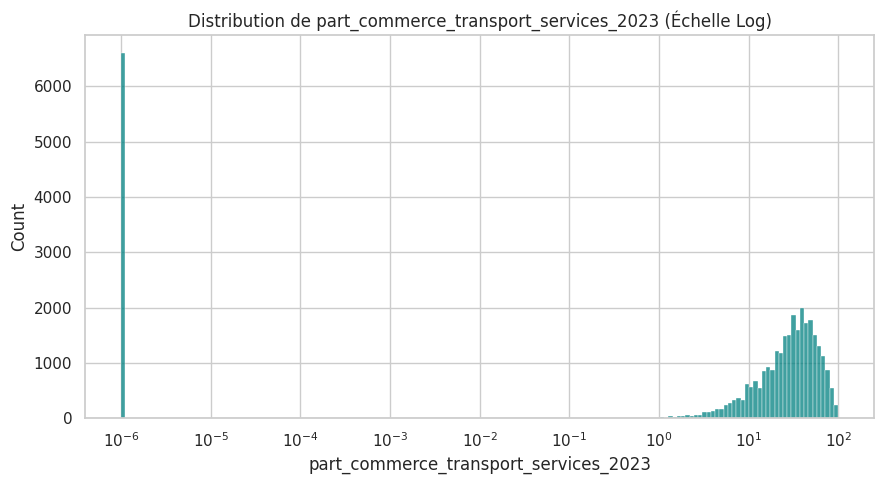

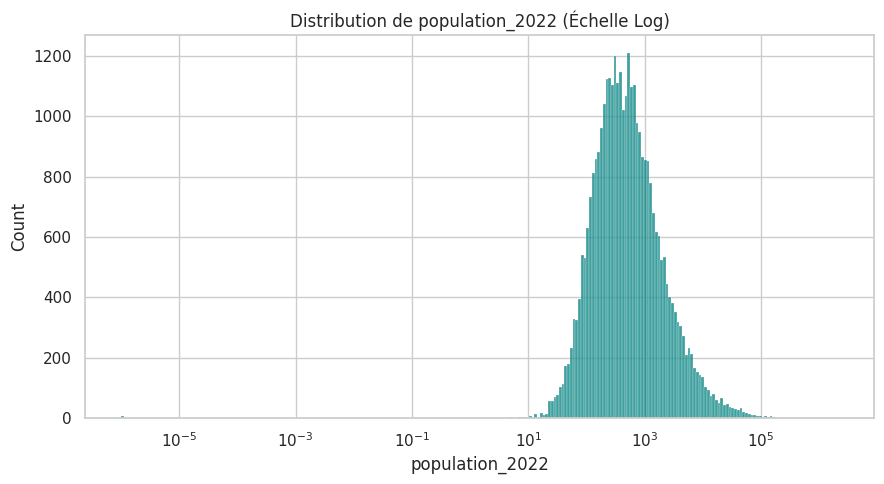

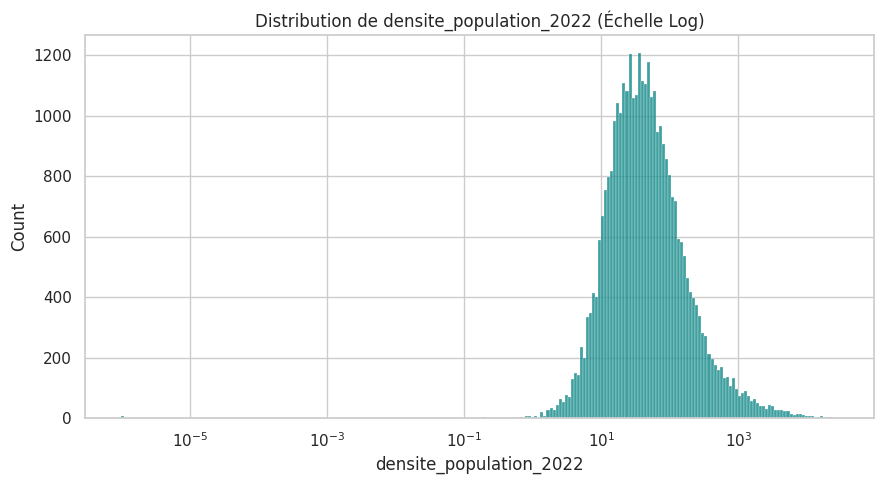

Graphiques de distribution générés dans 'output/Desc_All_Cities'


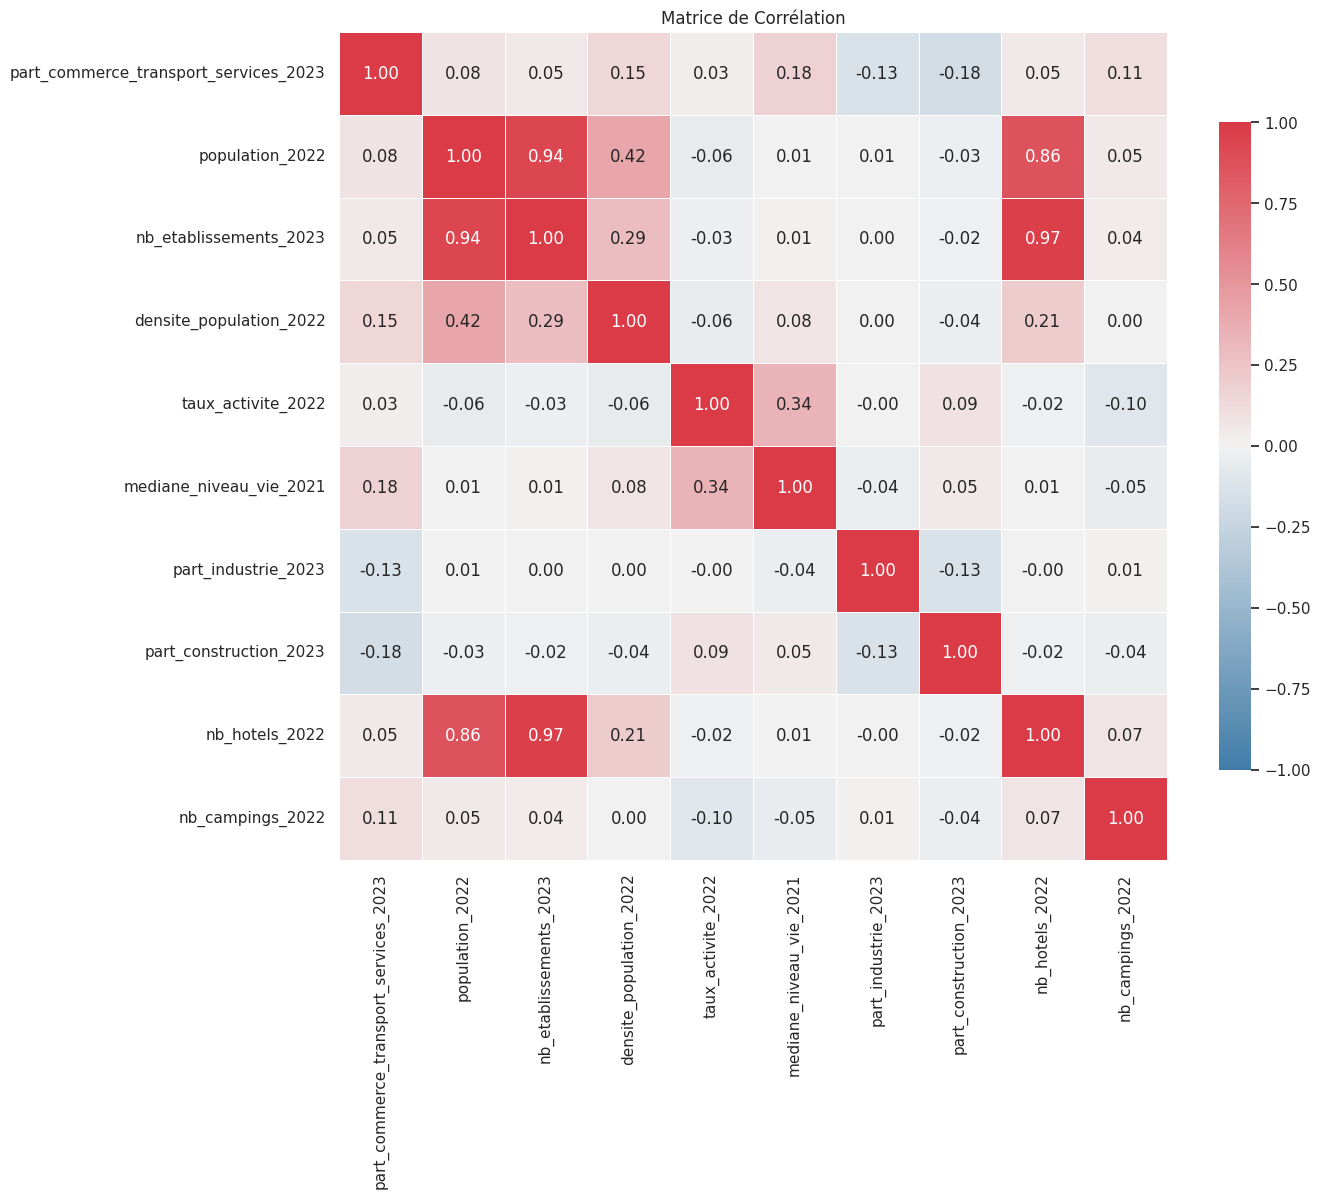

Matrice de corrélation générée.


In [3]:
# Visualisation des distributions
dists_to_save = ['nb_etablissements_2023', 'taux_activite_2022',
                 'mediane_niveau_vie_2021', 'part_industrie_2023',
                 'part_construction_2023', 'nb_hotels_2022', 'nb_campings_2022']
dists_to_save_and_plot = ['part_commerce_transport_services_2023', 'population_2022', 'densite_population_2022']
viz.plot_distributions(df_villes_clean, dists_to_save, display=False)
viz.plot_distributions(df_villes_clean, dists_to_save_and_plot, display=True)

print("Graphiques de distribution générés dans 'output/Desc_All_Cities'")


# Matrice de Corrélation
viz.plot_correlation_heatmap(df_villes_clean, display=True)
print("Matrice de corrélation générée.")

Analyse des distributions:

Analyse du corrélogramme: 

## Partie 3 : Fusion avec les données Qualité de l'Air (Geodair)
Maintenant que nous en savons plus les villes de France, il est temps de comparer avec les villes ayant des stations de mesure. Pour cela, commençons par joindre les données des relevés de pollution avec les données éco-démo des villes dans lesquelles ces relevés sont effectués.

In [4]:
# 5. Chargement Geodair et Merge
geodair = pd.read_csv("data/processed_data/geodair_2022_villes_codgeo2.csv", sep=",")

# Préparation et fusion (gestion des codgeo, types)
df_etude_complete = prep.prepare_geodair_data(geodair, df_villes_clean)

# Sauvegarde du dataset complet
df_etude_complete.to_csv("data/processed_data/data_etude_villes_relevees.csv", index=False, sep=";")

print(f"Dataset Étude Complet : {df_etude_complete.shape}")

Dataset Étude Complet : (2049, 38)


## Partie 4 : Agrégation et Analyse Comparative
Enfin, avant de mener nos analyses, remarquons que certaines villes possèdent plusieurs points de mesure. Pour n'avoir qu'un point par ville et par polluant, on agrège les valeurs des relevés au sein d'une même ville en prenant la moyenne de ceux-ci.

In [7]:
# Agrégation par Polluant et Ville
df_groupe = prep.aggregate_by_pollutant(df_etude_complete)

polluants = df_groupe["polluant"].unique()
print(f"Polluants identifiés : {polluants}")

       polluant             ville  valeur  valeur_brute codgeo  \
0    NOX as NO2              Agde     9.0      9.232302  34003   
1    NOX as NO2          Airvault     7.0      7.320025  79005   
2    NOX as NO2   Aix-en-Provence    37.5     37.903626  13001   
3    NOX as NO2              Albi    16.0     16.240348  81004   
4    NOX as NO2             Ambès     7.0      7.228952  33004   
..          ...               ...     ...           ...    ...   
908       PM2.5  Villiers-en-Bois     8.0      7.901511  79350   
909       PM2.5   Vitry-sur-Seine    10.0     10.473141  94081   
910       PM2.5            Yzeure    12.0     11.685267   3321   
911       PM2.5           Épernay     8.0      8.350219  51230   
912       PM2.5            Évreux     9.0      8.688785  27229   

          nom_commune  population_2022  mediane_niveau_vie_2021  \
0                Agde          29612.0                  20410.0   
1            Airvault           3295.0                  21280.0   
2     

Pour chacun de nos 4 polluants, nous étudions l'échantillon de villes associé. Pour préparer les analyses suivantes, nous divisons notre dataset en 4 (un dataset par polluant).

Pour les analyses, nous comparons:

- Le proportion de petites/moyennes/grandes villes de nos échantillons
- Les moyennes des variables éco-démo.
- Les distributions des variables éco-démo.

In [8]:
polluants = df_groupe["polluant"].unique()
print(f"Polluants identifiés : {polluants}")
# 7Génération des Datasets par Polluant et Plots Comparatifs
vars_eco = [
    "population_2022", "mediane_niveau_vie_2021",
    "densite_population_2022",
    "part_commerce_transport_services_2023",
    "part_industrie_2023", "nb_hotels_2022", "nb_etablissements_2023", "taux_activite_2022",
    "part_construction_2023", "nb_campings_2022"
]

for pol in polluants:
    print(f"--- Traitement : {pol} ---")
    
    # 1. Filtre et Sauvegarde
    df_pol = df_groupe[df_groupe["polluant"] == pol]
    df_pol.to_csv(f"data/processed_data/BDD_par_polluant/dataset_{pol}_final.csv", index=False, sep=';')

    # 2. Comparaison des proportions de petites, moyennes et grandes villes
    stats = prep.analyze_city_size_distribution(df_pol, pol)
    display(stats)
    
    # 3. Plots Comparatifs (France vs Echantillon)
    viz.plot_comparative_distributions(
        df_sample=df_pol, 
        df_france=df_villes_clean, 
        polluant_name=pol, 
        vars_eco=vars_eco
    )

    # 4. Etude des corrélations entre la concentration de polluant et les variables éco-démo.
    viz.plot_correlation_heatmap(df_pol, pol=pol)

print("\nAnalyse terminée. Tous les graphiques sont générés.")

Polluants identifiés : ['NOX as NO2' 'O3' 'PM10' 'PM2.5']
--- Traitement : NOX as NO2 ---

>> Distribution par taille de ville pour : NOX as NO2


,Nb_Villes,Proportion (%),Moyenne_Mesures
taille_ville,,,
Rurale (<2k),26,11.98,7.731
Petite (2-10k),30,13.82,20.833
Moyenne (10-50k),87,40.09,22.546
Grande (>50k),68,31.34,31.236


--- Traitement : O3 ---

>> Distribution par taille de ville pour : O3


,Nb_Villes,Proportion (%),Moyenne_Mesures
taille_ville,,,
Rurale (<2k),44,16.54,62.545
Petite (2-10k),46,17.29,56.457
Moyenne (10-50k),109,40.98,54.917
Grande (>50k),61,22.93,56.049


--- Traitement : PM10 ---

>> Distribution par taille de ville pour : PM10


,Nb_Villes,Proportion (%),Moyenne_Mesures
taille_ville,,,
Rurale (<2k),25,9.54,14.240
Petite (2-10k),46,17.56,16.957
Moyenne (10-50k),114,43.51,17.009
Grande (>50k),70,26.72,18.291


--- Traitement : PM2.5 ---

>> Distribution par taille de ville pour : PM2.5


,Nb_Villes,Proportion (%),Moyenne_Mesures
taille_ville,,,
Rurale (<2k),20,11.90,8.050
Petite (2-10k),15,8.93,10.100
Moyenne (10-50k),70,41.67,9.979
Grande (>50k),58,34.52,10.233



Analyse terminée. Tous les graphiques sont générés.


# Partie 5: Modélisation par arbres
Dans cette partie, nous tentons d'expliquer/prédire la qualité de l'air observée dans une ville à l'aide de ses caractéristiques éco-démo. Seuls les arbres CART seront considérés. En effet, il n'est pas envisageable d'aller plus loin avec des Random Forest faute d'observations (Autour de 200 observations par polluant).

In [9]:
# Configuration
polluants = ["NOX as NO2", "O3", "PM10", "PM2.5"]
features = [
    "population_2022", 
    "mediane_niveau_vie_2021",
    "densite_population_2022",
    "part_commerce_transport_services_2023",
    "part_industrie_2023", 
    "nb_hotels_2022", 
    "nb_etablissements_2023", 
    "taux_activite_2022",
    "part_construction_2023", 
    "nb_campings_2022"
]
target = "valeur"
seed = 2003


PROCESSING: NOX as NO2
Meilleurs params. : {'ccp_alpha': 0.0, 'max_depth': 3, 'max_leaf_nodes': 5, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 20, 'min_samples_split': 2}
R2: 0.233


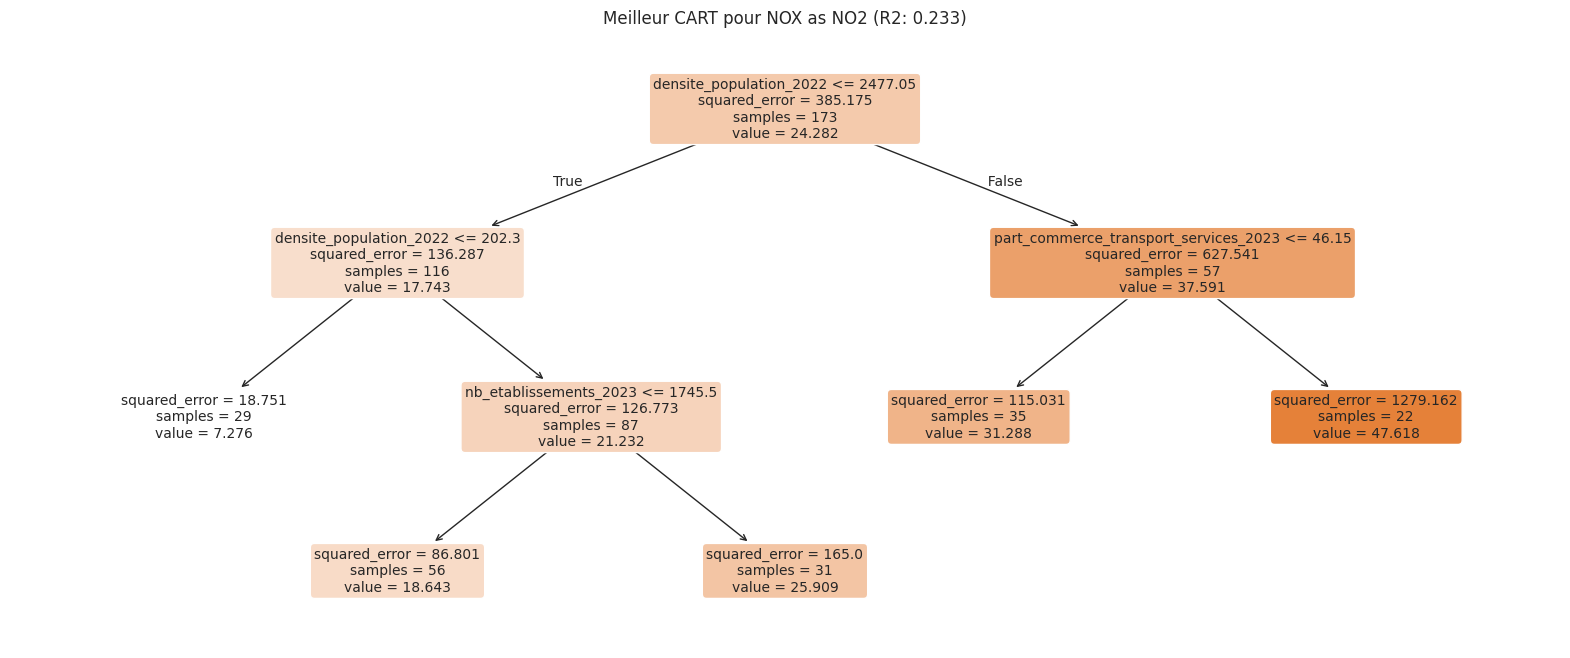


PROCESSING: O3
Meilleurs params. : {'ccp_alpha': 0.0, 'max_depth': None, 'max_leaf_nodes': 5, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 2, 'min_samples_split': 2}
R2: -0.317


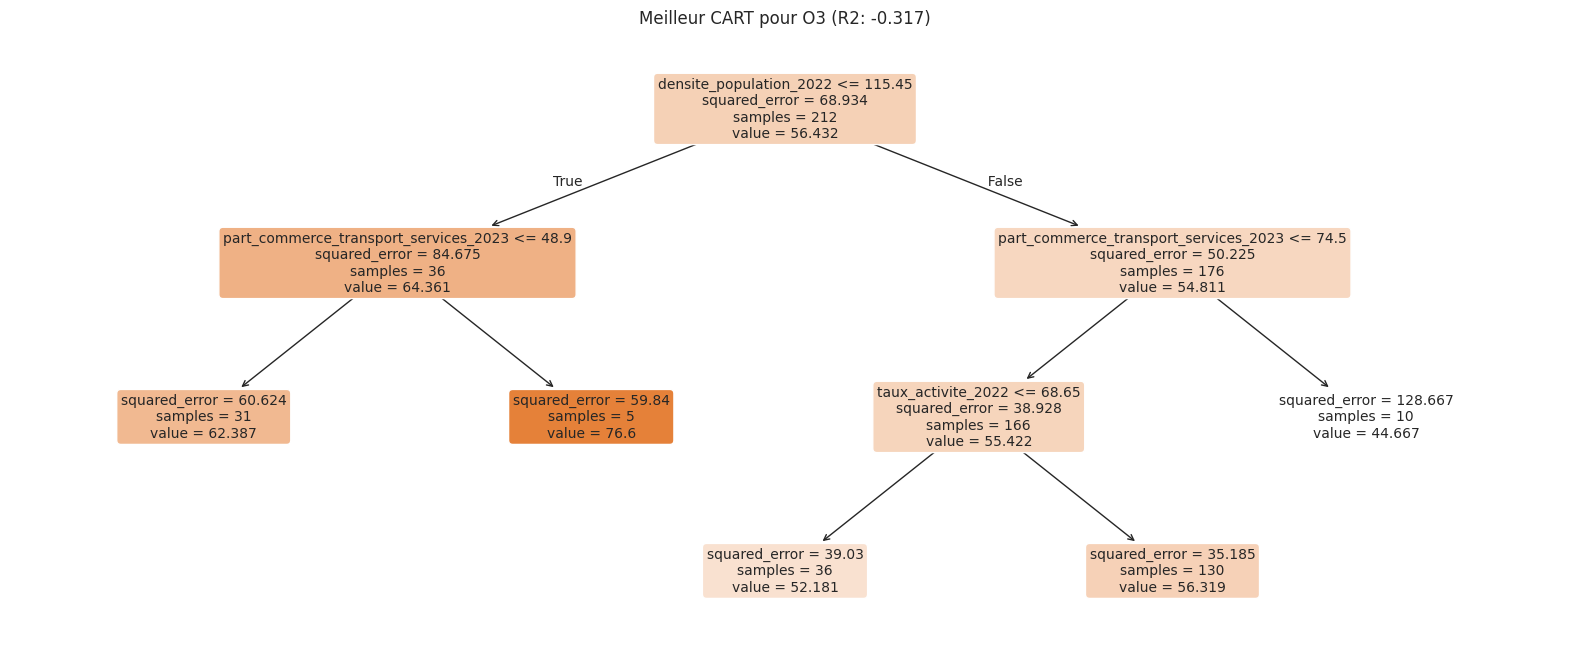


PROCESSING: PM10
Meilleurs params. : {'ccp_alpha': 0.0, 'max_depth': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 30, 'min_samples_split': 2}
R2: 0.148


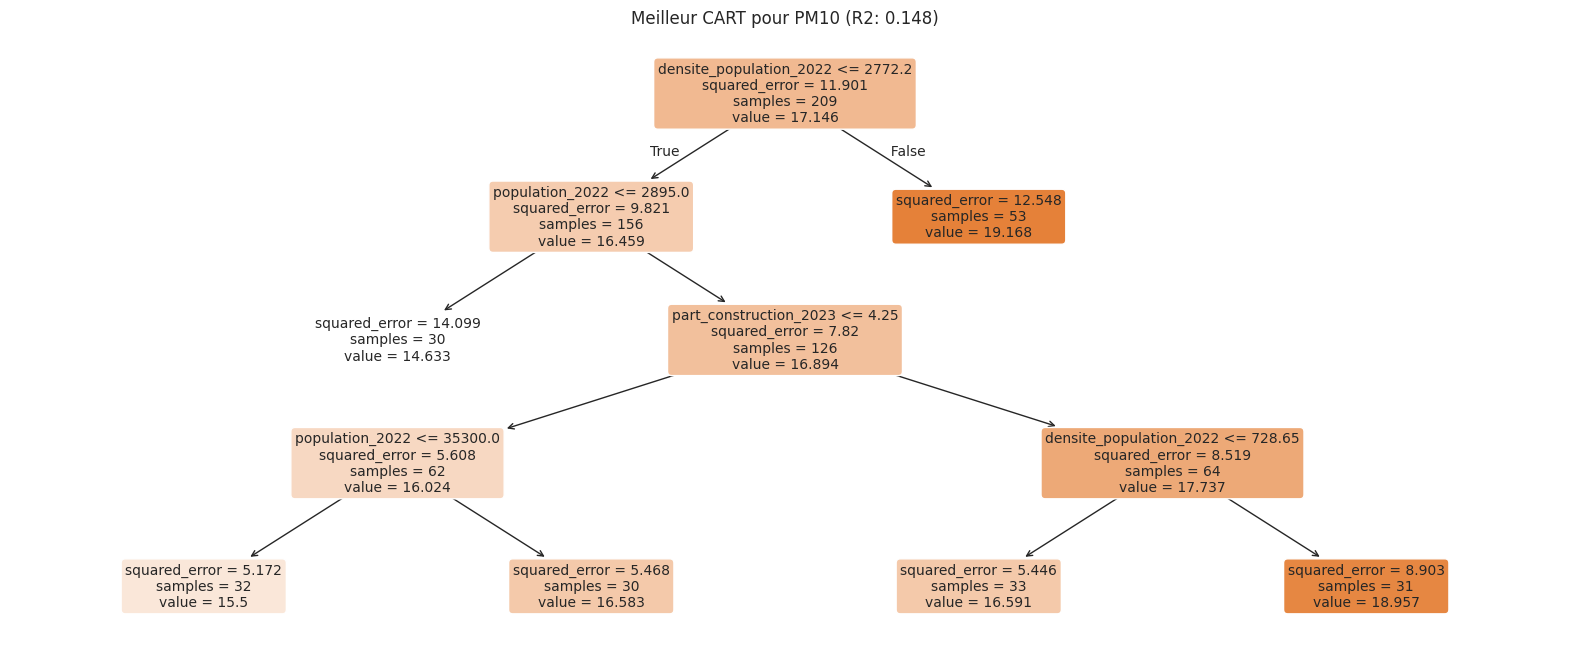


PROCESSING: PM2.5
Meilleurs params. : {'ccp_alpha': 0.0, 'max_depth': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 30, 'min_samples_split': 2}
R2: -0.043


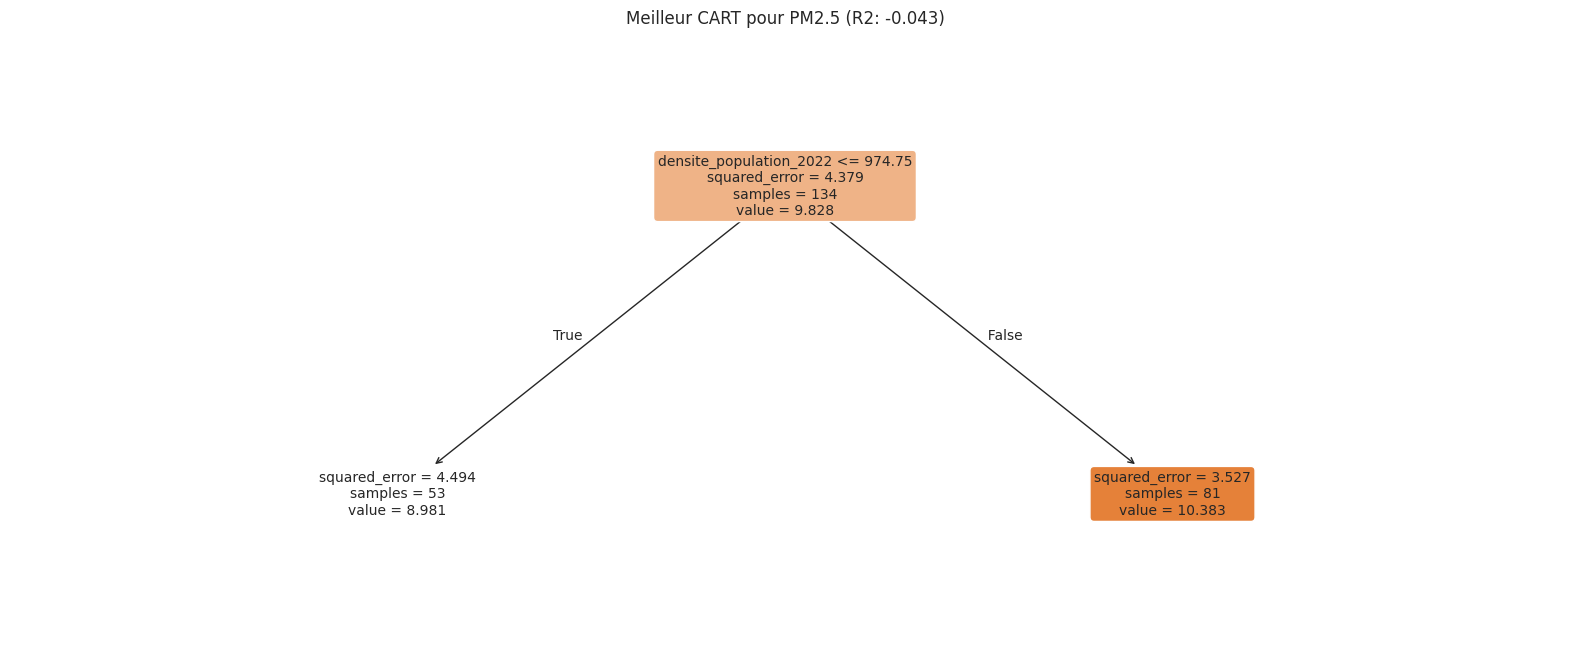

In [10]:
# Tableau dans lequel seront stockés les métriques de chaque arbre
results_table = []

# Boucle principale

for pol in polluants:
    print(f"\n{'='*40}")
    print(f"PROCESSING: {pol}")
    print(f"{'='*40}")
    
    # Import des données
    file_path = f"data/processed_data/BDD_par_polluant/dataset_{pol}_final.csv"
    df = pd.read_csv(file_path, sep=';')

    X = df[features]
    y = df[target]
    
    # Split des données en éch. de train et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Implémentation du GridSearch (pour trouver le meilleur arbre par polluant)
    param_grid = {
        # 1. Tree Geometry (Growth Control)
        'max_depth': [None, 3, 5, 7, 10, 15],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10, 20, 30],
        'max_leaf_nodes': [None, 5, 10, 20],
        
        # 2. Feature & Impurity Thresholds
        'min_impurity_decrease': [0.001, 0.01, 0.1],
        
        # 3. Pruning
        'ccp_alpha': [0.0] + list(np.logspace(-4, -1, 5)) # From 0.0001 to 0.1
    }
    
    model = DecisionTreeRegressor(criterion="squared_error", random_state=seed)
    
    # Cross-Validation
    grid = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    
    # Prédiction et calcul des métriques
    y_pred = best_model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Sauvegarde des résultats
    results_table.append({
        "Pollutant": pol,
        "R2 Score": round(r2, 3),
        "RMSE": round(rmse, 3),
        "MAE": round(mae, 3),
        "Best Depth": best_model.max_depth,
        "Min Samples Split": best_model.min_samples_split,
        "Min Samples Leaf": best_model.min_samples_leaf,
        "Max leaf nodes": best_model.max_leaf_nodes,
        "Max features": best_model.max_features,
        "Min impurity decrease": best_model.min_impurity_decrease,
        "CCP Alpha": best_model.ccp_alpha
    })
    
    print(f"Meilleurs params. : {grid.best_params_}")
    print(f"R2: {r2:.3f}")
    
    # Affichage de l'arbre
    plt.figure(figsize=(20, 8))
    plot_tree(
        best_model, 
        feature_names=features, 
        filled=True, 
        rounded=True, 
        fontsize=10, 
    )
    plt.title(f"Meilleur CART pour {pol} (R2: {r2:.3f})")
    plt.show()

In [11]:
# Affichage des résultats dans un tableau final

print("\n" + "#"*30)
print(" Résultats finaux ")
print("#"*30)
df_results = pd.DataFrame(results_table)
# Par ordre de performance (R2)
df_results = df_results.sort_values(by="R2 Score", ascending=False)
display(df_results)


##############################
 Résultats finaux 
##############################


,Pollutant,R2 Score,RMSE,MAE,Best Depth,Min Samples Split,Min Samples Leaf,Max leaf nodes,Max features,Min impurity decrease,CCP Alpha
0,NOX as NO2,0.233,14.895,9.992,3.0,2,20,5.0,None,0.001,0.0
2,PM10,0.148,3.392,2.403,NaN,2,30,NaN,None,0.001,0.0
3,PM2.5,-0.043,1.866,1.316,NaN,2,30,NaN,None,0.100,0.0
1,O3,-0.317,9.813,7.251,NaN,2,2,5.0,None,0.001,0.0
